# Making Molecule Files for HFVQE

In this tutorial we describe the process of making the molecular data files necessary to run the HFVQE code.  We focus on how to use the OpenFermion plugin modules to generate molecular files with canonical Hartree-Fock and generate integrals in a given atomic orbital basis set.  We also provide helper functions to run variational Hartree-Fock simulating the experiment and generating initial parameters.

This tutorial will follow the code in the `hfvqe/molecular_data` module of Recirq for constructing MolecularData objects and getting atomic orbital integrals.

To run this notebook you will need to have OpenFermion-pyscf, pyscf, scipy, numpy, and matplotlib installed.

In [122]:
# PRELIMINARY IMPORTS AND HELPER FUNCTION
import os
import numpy
import scipy

from openfermion.ops import general_basis_change

from recirq.hfvqe.molecular_data.molecular_data_construction import (h6_linear_molecule, 
                                                                     h8_linear_molecule, 
                                                                     h10_linear_molecule,
                                                                     h12_linear_molecule, 
                                                                     get_ao_integrals)
from recirq.hfvqe.gradient_hf import rhf_minimization, rhf_func_generator
from recirq.hfvqe.objective import RestrictedHartreeFockObjective, generate_hamiltonian


def make_rhf_objective(molecule):
    # coverage: ignore
    S, Hcore, TEI = get_ao_integrals(molecule)
    _, X = scipy.linalg.eigh(Hcore, S)

    molecular_hamiltonian = generate_hamiltonian(
        general_basis_change(Hcore, X, (1, 0)),
        numpy.einsum('psqr', general_basis_change(TEI, X, (1, 0, 1, 0)),
                     molecule.nuclear_repulsion))

    rhf_objective = RestrictedHartreeFockObjective(molecular_hamiltonian,
                                                   molecule.n_electrons)
    return rhf_objective, S, Hcore, TEI

## Hydrogen Chain MolecularData

We provide helper functions in the `hfvqe` module to generate the Hydrogen chain data.  Each chain is constructed using OpenFermion and Psi4 via the OpenFermion-Psi4 plugin.  We will use creating H6 with equal spacing between Hydrogen atoms as an example.  

In [123]:
from openfermion import MolecularData, general_basis_change
from openfermionpyscf import run_pyscf
import numpy as np
import scipy as sp

In [124]:
n_hydrogens = 6
bond_distance = 1.3 # in Angstroms
molecule = MolecularData(
    geometry=[('H', (0, 0, i * bond_distance)) for i in range(n_hydrogens)],
    charge=0,
    basis='6-31g',
    multiplicity=1,
    description=f"linear_r-{bond_distance}")

The previous lines set up the MolecularData file.  We can now use pyscf to either run a full self-consistent-field Hartree-Fock calculation or get atomic integrals.  Via Openfermion-Pyscf we provide an interface to running Hartree-Fock, coupled-cluster, second order perturbation theory, configuration-interaction singles-doubles, and full configuration interaction.  Many of these methods depend on parameters such as convergence criteria or initial vectors in the subspace expansion.  `run_pyscf` assumes common defaults which are appropriate for most systems. Below we will run default Hartree-Fock and CISD.

In [125]:
molecule = run_pyscf(molecule, run_scf=True, run_cisd=True)

In [127]:
print(molecule.hf_energy, molecule.cisd_energy)  #hartree-Fock energy, CISD energy

-3.102591009910493 -3.222103463829712


The `MolecularData` file holds almost all information that is required for post-Hartree-Fock correlated calculations.  For example, we provide access to integrals as attributes of `MolecularData`.  

In [128]:
print("Overlap Ints")
print(molecule.overlap_integrals)

print()
print("One-electron integrals")
print(molecule.one_body_integrals)

Overlap Ints
[[1.00000000e+00 6.58292049e-01 1.07450262e-01 2.97950190e-01
  2.92936786e-04 2.79155456e-02 1.86658314e-08 5.52805483e-04
  2.50532789e-14 2.34306448e-06 7.06186034e-22 2.12361769e-09]
 [6.58292049e-01 1.00000000e+00 2.97950190e-01 6.14673658e-01
  2.79155456e-02 1.42750753e-01 5.52805483e-04 1.25256830e-02
  2.34306448e-06 4.15253811e-04 2.12361769e-09 5.20133758e-06]
 [1.07450262e-01 2.97950190e-01 1.00000000e+00 6.58292049e-01
  1.07450262e-01 2.97950190e-01 2.92936786e-04 2.79155456e-02
  1.86658314e-08 5.52805483e-04 2.50532789e-14 2.34306448e-06]
 [2.97950190e-01 6.14673658e-01 6.58292049e-01 1.00000000e+00
  2.97950190e-01 6.14673658e-01 2.79155456e-02 1.42750753e-01
  5.52805483e-04 1.25256830e-02 2.34306448e-06 4.15253811e-04]
 [2.92936786e-04 2.79155456e-02 1.07450262e-01 2.97950190e-01
  1.00000000e+00 6.58292049e-01 1.07450262e-01 2.97950190e-01
  2.92936786e-04 2.79155456e-02 1.86658314e-08 5.52805483e-04]
 [2.79155456e-02 1.42750753e-01 2.97950190e-01 6.146

For the Hartree-Fock experiment we will need to get the atomic basis integrals from the molecular integrals.  We can use the identity $C^{\dagger}SC = I$ to reverse the transformation on the one and two electron integrals.

In [106]:
oei_mo,  tei_mo = molecule.one_body_integrals, molecule.two_body_integrals
C = molecule.canonical_orbitals
S = molecule.overlap_integrals
oei_ao = general_basis_change(oei_mo, C.conj().T @ S, key=(1, 0))

In [107]:
print(oei_ao)

[[-1.18698197e+00 -1.09398249e+00 -2.90382070e-01 -5.73478152e-01
  -1.91588194e-03 -7.08618226e-02 -2.34028697e-07 -1.97458486e-03
  -5.37597744e-13 -1.18105831e-05  2.22044605e-16 -1.46391008e-08]
 [-1.09398249e+00 -1.30863711e+00 -6.31325886e-01 -9.69723130e-01
  -7.72940958e-02 -2.75295274e-01 -2.08668247e-03 -2.98813560e-02
  -1.21151858e-05 -1.23417943e-03 -1.46391012e-08 -1.91822048e-05]
 [-2.90382070e-01 -6.31325886e-01 -1.51260669e+00 -1.30790890e+00
  -3.09964749e-01 -6.50637018e-01 -1.94571033e-03 -7.66467737e-02
  -2.34897054e-07 -2.06566594e-03 -5.37958567e-13 -1.21151858e-05]
 [-5.73478152e-01 -9.69723130e-01 -1.30790890e+00 -1.61455088e+00
  -6.69270617e-01 -1.08041337e+00 -7.82781452e-02 -2.89819977e-01
  -2.06566594e-03 -3.04640626e-02 -1.18105831e-05 -1.23417943e-03]
 [-1.91588194e-03 -7.72940958e-02 -3.09964749e-01 -6.69270617e-01
  -1.61437154e+00 -1.37489989e+00 -3.14983314e-01 -6.74320764e-01
  -1.94571033e-03 -7.82781452e-02 -2.34028697e-07 -2.08668247e-03]
 [-7.

In [108]:
print(oei_mo)

[[-1.87432473e+00 -1.04387332e-15 -1.16409397e-01  8.92719031e-16
  -6.15079850e-02  5.64296790e-16 -1.25731117e-01 -1.24763371e-15
  -5.89300819e-02 -1.46224258e-16  2.71519013e-03 -7.06223980e-16]
 [-1.18650828e-15 -1.69304317e+00 -2.91895510e-16 -1.65551634e-01
   1.02277616e-16  4.41325654e-02  2.13638452e-15 -1.00494695e-01
  -4.81325561e-15  8.00967125e-02 -1.41605259e-15  6.99099285e-03]
 [-1.16409397e-01 -1.77265232e-16 -1.61481611e+00  1.97821568e-16
   1.42975424e-01 -9.04862105e-16  1.99561985e-02  1.13630860e-15
  -9.93297282e-02 -4.36044349e-15 -8.38903468e-02  1.81807366e-15]
 [ 7.35593837e-16 -1.65551634e-01  2.48908542e-16 -1.47182278e+00
   3.41029556e-16 -1.55554532e-01 -1.46797386e-15  6.81485313e-02
  -2.85457768e-15  1.47405321e-01 -6.31045753e-15 -4.83500512e-02]
 [-6.15079850e-02 -1.28186273e-16  1.42975424e-01  3.07483932e-16
  -1.29158630e+00 -1.58743514e-15  5.71950545e-02  4.95828103e-15
  -1.32456629e-01  1.46524593e-15  1.56350374e-01 -4.16227756e-15]
 [-7.

In [131]:
# Use pyscf to get atomic integrals and compare to transformed integrals from above
pyscf_mol = molecule._pyscf_data['mol']
t = pyscf_mol.intor('int1e_kin')
v = pyscf_mol.intor('int1e_nuc')
hcore = t + v

In [132]:
assert np.allclose(hcore, oei_ao)

 The two-electron integrals can also be acquired from the `pyscf_mol` object or we can use the `general_basis_change` to transform the two-electron integrals back into the AO basis.

In [133]:
tei_ao = general_basis_change(tei_mo, C.conj().T @ S, key=(1, 1, 0, 0))  # Transform the two-electron integrals

In [134]:
eri_ao = np.einsum('ijkl->iklj', pyscf_mol.intor('int2e', aosym='s1'))  # re-ordering for chem->physics storage of the integrals

In [135]:
assert np.allclose(tei_ao, eri_ao)
assert not np.allclose(tei_ao, tei_mo)

We also provide a function in `recirq.hfvqe.molecular_data.molecular_data_construction` that uses psi4 to generate atomic integrals for the HF-VQE study.  Once the atomic orbital integrals are obtained we can perform the first step in setting up the HF-VQE experiment.  This involes transforming the integrals to the core-orbital basis and building an `RestrictedHartreeFockObjective`. 

In [136]:
_, X = sp.linalg.eigh(oei_ao, S)  # diagonalize the AO-core Hamiltonian

obi = general_basis_change(oei_ao, X, (1, 0))
tbi = np.einsum('psqr', general_basis_change(pyscf_mol.intor('int2e', aosym='s1'), X, (1, 0, 1, 0)))
molecular_hamiltonian = generate_hamiltonian(obi, tbi,
                                             molecule.nuclear_repulsion)

rhf_objective = RestrictedHartreeFockObjective(molecular_hamiltonian,
                                               molecule.n_electrons)

To get initial parameters we can simulate the Hartree-Fock experiment which is performing variational-Hartree-Fock theory.

In [138]:
from recirq.hfvqe.gradient_hf import rhf_minimization, rhf_func_generator
scipy_result = rhf_minimization(rhf_objective, verbose=True)  # uses conjugate gradient to solve non-linear hartree-fock functional

Optimization terminated successfully.
         Current function value: -3.102591
         Iterations: 12
         Function evaluations: 25
         Gradient evaluations: 25


In [139]:
print(molecule.hf_energy, scipy_result.fun)

-3.102591009910493 -3.1025910099026466


In [140]:
print("Initial Parameters for HF-VQE Study ", scipy_result.x)

Initial Parameters for HF-VQE Study  [-2.38602650e-20 -4.73763008e-01 -3.58388605e-20 -1.36102259e-02
 -3.29952680e-21  4.44832962e-01  4.98042730e-21 -2.59144562e-01
 -2.05938395e-20  1.17062375e-01 -4.68386796e-21  7.61172517e-03
  2.57166245e-20  9.47442448e-02 -3.66038306e-21 -2.71237051e-04
  1.86395426e-20 -7.30836704e-02  3.96538974e-20 -4.10271133e-02
 -1.44611303e-20 -4.52955415e-03 -1.03127292e-20 -8.54284651e-02
 -2.01808961e-20 -4.71103578e-02 -4.88098067e-21]


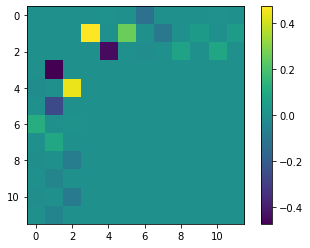

In [141]:
# Explicity build kappa matrix
from recirq.hfvqe.circuits import rhf_params_to_matrix
import matplotlib.pyplot as plt
kappa = rhf_params_to_matrix(scipy_result.x, len(rhf_objective.occ) + len(rhf_objective.virt), rhf_objective.occ,
            rhf_objective.virt)
plt.imshow(kappa)
plt.colorbar()